# Food-101 using ResNet50

## Contents:

- Overview
- Loading data
- Exploration of data
- Division into training, validation, and test data
- Define model
- Train model
- Test model (Basic and TTA)
- Exploration of failures
- Conclusions

## Overview

In this notebook I am practicing skills that I learnt during the Coursera Deep Learning specialization, specifically transfer learning.

One of the data science fellowships I have come across is Fellowship.ai. https://fellowship.ai/
As part of their application process they have several challenges to complete, including one using the Food-101 dataset. Doing this challenge is a good way to practice my deep learning skills.

The initial models I trained struggled with this dataset. I initially implemented transfer learning with ResNet50 in tensorflow.keras, but only acheived about 60% accuracy on the test set. However, this model worked sufficiently well with a different dataset (Stanford Dogs, https://github.com/ruthschulz/data_science_playground/blob/master/stanford-dogs/StanfordDogs.ipynb). I decided I needed more control over the data going into the network and the training, and was learning Pytorch in Udacity's Secure and Private AI Challenge course, so I figured that implementing transfer learning using Pytorch would be a good plan.

I have used google colab to train the model, which has been excellent, although it does have a tendancy to reset the runtime every so often, so I have found it helpful to often save the current state of the model and to have the dataset on google drive ready to copy across rather than re-download.
https://colab.research.google.com

The model trained here reaches a top-1 accuracy of 73.2% top-5 accuracy of 91.5%. With test time augmentation, the model reaches a top-1 accuracy of 75.8% and a top-5 accuracy of 93.0%.

Possible ways to improve on this would be to adjust the classification layers of the network, and scaling the learning rates for the different layers.

### Food-101

https://www.vision.ee.ethz.ch/datasets_extra/food-101/

This dataset contains images of foods from 101 categories.
Files are also provided that divide the dataset up into training and test sets (respectively containing 750 and 250 images of each category)

The original paper used Random Forests for classification and reached 56.40% accuracy.

I have also found a paper that reached 77.4% accuracy using a GoogLeNet model pre-trained on ImageNet and finetuned using Food-101. https://arxiv.org/abs/1606.05675

The following reached 86.97% Top-1 Accuracy and 97.42% Top-5 Accuracy
https://github.com/stratospark/food-101-keras


### Fellowship.ai Challenge: 

https://fellowship.ai/challenge

"Food-101 is a challenging vision problem, but everyone can relate to it.  Recent SoTA is ~80% top-1, 90% top-5.  These approaches rely on lots of TTA, large networks and  even novel architectures.

Train a decent model >85% accuracy for top-1 for the test set, using a ResNet50 or smaller network with a reasonable set of augmentations."

- SoTA = State of the Art
- top-1 = if the correct category is the top category chosen by the model
- top-5 = if the correct category is in the top five categories chosen by the model
- TTA = Test Time Augmentation (generate the prediction using the model X times using different augmentations e.g. flip horizontal or zoom, then select the category with the highest mean value)

## Loading Data

The Food-101 dataset is available at https://www.vision.ee.ethz.ch/datasets_extra/food-101/

This dataset can be loaded to google colab using:

!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

!tar xzvf food-101.tar.gz

The dataset is also available on Kaggle at https://www.kaggle.com/dansbecker/food-101

Kaggle datasets can be loaded to google colab using the instructions here:

https://towardsdatascience.com/setting-up-kaggle-in-google-colab-ebb281b61463

Then the dataset can be unzipped using:

!unzip -o -q \food-101.zip

After I got annoyed with waiting to download the data again every time the runtime reset, I copied the dataset to my google drive and copied it back into runtime when needed.

In [0]:
# Mount google drive for easy access to dataset 
# and for transferring across saved models
import os
if not os.path.exists("./gdrive"):
  from google.colab import drive
  drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Copy across dataset and unzip
import shutil
if not os.path.exists("./food-101"):
  shutil.copyfile( './gdrive/My Drive/Colab Notebooks/food-101.tar.gz', 'food-101.tar.gz')
  !tar xzf food-101.tar.gz   

## Exploration of Data

From the website:
"We introduce a challenging data set of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.""

In [0]:
!ls {'./food-101'}

images	license_agreement.txt  meta  README.txt  test_images


In [0]:
!ls {'./food-101/images'}

apple_pie	    eggs_benedict	     onion_rings
baby_back_ribs	    escargots		     oysters
baklava		    falafel		     pad_thai
beef_carpaccio	    filet_mignon	     paella
beef_tartare	    fish_and_chips	     pancakes
beet_salad	    foie_gras		     panna_cotta
beignets	    french_fries	     peking_duck
bibimbap	    french_onion_soup	     pho
bread_pudding	    french_toast	     pizza
breakfast_burrito   fried_calamari	     pork_chop
bruschetta	    fried_rice		     poutine
caesar_salad	    frozen_yogurt	     prime_rib
cannoli		    garlic_bread	     pulled_pork_sandwich
caprese_salad	    gnocchi		     ramen
carrot_cake	    greek_salad		     ravioli
ceviche		    grilled_cheese_sandwich  red_velvet_cake
cheesecake	    grilled_salmon	     risotto
cheese_plate	    guacamole		     samosa
chicken_curry	    gyoza		     sashimi
chicken_quesadilla  hamburger		     scallops
chicken_wings	    hot_and_sour_soup	     seaweed_salad
chocolate_cake	    hot_dog		     shrimp_and_grits
chocolate_mousse    huevo

In [0]:
!ls {'./food-101/meta'}

classes.txt  labels.txt  test.json  test.txt  train.json  train.txt


In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as img
plt.rcParams['font.size'] = 14
import random

%matplotlib inline

[]

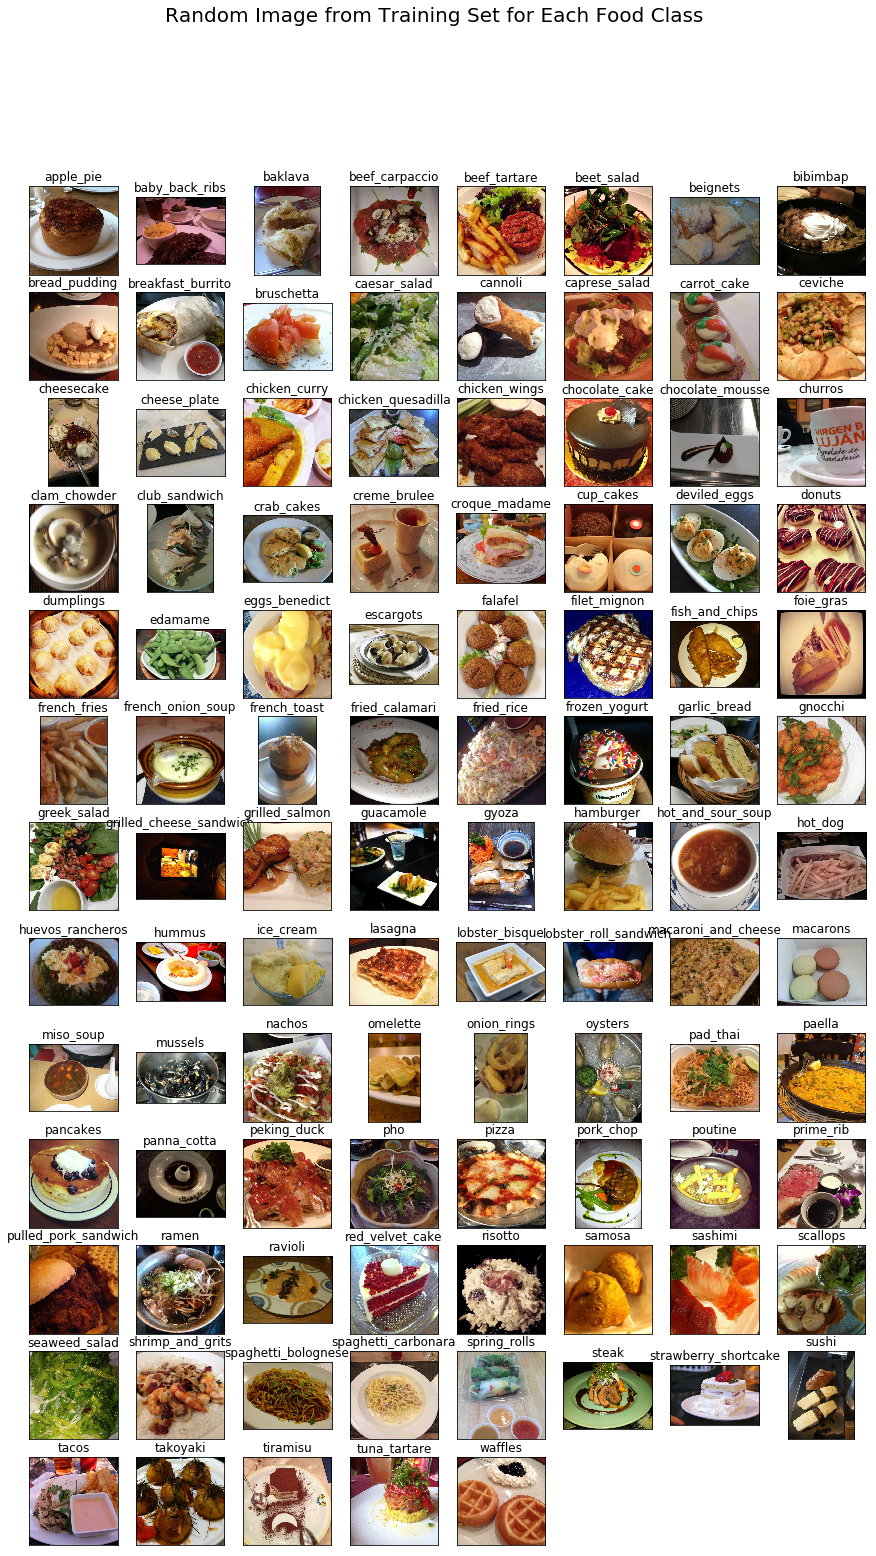

In [0]:
rows = 13
cols = 8
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Training Set for Each Food Class', fontsize=20)
train_file = open("./food-101/meta/train.txt","r")
current_cat = ""
i = 0
j = 0
for line in train_file:
    [category,index] = line.split('/')
    if (category != current_cat):
        current_cat = category
        rand_index = random.randint(0,749)
        curr_index = 0
    if (rand_index==curr_index):
        img = plt.imread("./food-101/images/" + line[:-1] + ".jpg")
        ax[j][i].imshow(img)
        ax[j][i].set_title(current_cat)
        i = i + 1
        if i==cols:
            i = 0
            j = j+1
    curr_index = curr_index + 1
train_file.close()
for row in range(j,rows):
    for col in range(i,cols):
        ax[row][col].axis('off')
plt.setp(ax, xticks=[], yticks=[])

## Division into Training, Validation, and Test sets

Part of the meta data included with the Food-101 dataset is the training / test split used in the initial paper.

As the definition of the fellowship.ai challenge seemed to indicate that the target was to achieve 85% accuracy on the test set, I have used the defined training and test set.

No validation set has been assigned, and although I initially created a model without a validation set, I wanted to see what would happen with one. Although as my strategy was defined using the test set, it is probably still not quite an unbiased test set.

A tutorial that I found helpful regarding loading the training and testing sets for use with keras:

https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/

And for pytorch:

https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel


In [0]:
# Separate out test set from training set as specified in meta/test.txt
if not os.path.exists("./food-101/test_images"):

  test_file = open("./food-101/meta/test.txt","r")
  current_cat = ""
  for line in test_file:
      [category,index] = line.split('/')
      if (category != current_cat):
          current_cat = category
          if not os.path.exists("./food-101/test_images/" + current_cat):
              os.makedirs("./food-101/test_images/" + current_cat)
      shutil.move("./food-101/images/" + line[:-1] + ".jpg","./food-101/test_images/" + line[:-1] + ".jpg")
  test_file.close()

In [0]:
# Initialise class_list and n_classes
class_file = open("./food-101/meta/classes.txt")
class_list = []
for line in class_file:
    [cat,other] = line.split('\n')
    class_list.append(cat)
class_file.close()
print(class_list)
n_classes = len(class_list)
num_train_images = 75750
num_test_images = 25250
train_set_size = int(num_train_images / n_classes)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [0]:
# Create a validation set:
# for all classes
# choose random 10% of images (75 out of 750 training images)
# move to validation folder
import random

if not os.path.isfile('./gdrive/My Drive/Colab Notebooks/valid.txt'):

  train_file = open("./food-101/meta/train.txt","r")
  lines = train_file.readlines()
  train_file.close()

  valid_file = open("./food-101/meta/valid.txt","w")
  
  current_cat = ""
  for food_index in range(n_classes):
    indexes = []
    for i in range(int(train_set_size / 10)):
      rand_index = random.randint(0,train_set_size)
      while (rand_index in indexes):
        rand_index = random.randint(0,train_set_size)
      indexes.append(rand_index)
    indexes.sort()
    for img_index in range(int(train_set_size / 10)):
      gen_index = 0
      while(indexes[img_index] > gen_index):
        gen_index = gen_index + 1
      valid_file.write(lines[(food_index * train_set_size)+gen_index])

  valid_file.close()
  shutil.copyfile( 'valid.txt', './gdrive/My Drive/Colab Notebooks/valid.txt')

In [0]:
# Separate out validation set from training set as specified in meta/valid.txt
if not os.path.exists("./food-101/valid_images"):

  #valid_file = open("./food-101/meta/valid.txt","r")
  valid_file = open("./gdrive/My Drive/Colab Notebooks/valid.txt")
  current_cat = ""
  for line in valid_file:
      [category,index] = line.split('/')
      if (category != current_cat):
          current_cat = category
          if not os.path.exists("./food-101/valid_images/" + current_cat):
              os.makedirs("./food-101/valid_images/" + current_cat)
      shutil.move("./food-101/images/" + line[:-1] + ".jpg","./food-101/valid_images/" + line[:-1] + ".jpg")
  valid_file.close()
  


In [0]:
num_train_images = int(num_train_images - n_classes * (train_set_size / 10))
num_valid_images = int(n_classes * (train_set_size / 10))

In [0]:
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

In [0]:
import numpy as np
import pandas as pd
# Image manipulations
from PIL import Image
# Timing utility
from timeit import default_timer as timer
# For saving and loading history
import pickle

In [0]:
# Location of data
datadir = './food-101/'
traindir = datadir + 'images/'
validdir = datadir + 'valid_images/'
testdir = datadir + 'test_images/'

checkpoint_path = 'food101-resnet50-transfer-valid-1.pth'

# Change to fit hardware
batch_size = 128

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

Train on gpu: True


In [0]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Test set without augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test set with augmentation for Test Time Augmentation
    'augment-test':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'valid':
    datasets.ImageFolder(root=validdir, transform=image_transforms['test']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test']),
    'augment-test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['augment-test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'valid': DataLoader(data['valid'], batch_size=batch_size, shuffle=False),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=False),
    'augment-test': DataLoader(data['augment-test'], batch_size=batch_size, shuffle=False)
}

In [0]:
print("Train set: ", len(dataloaders['train'].dataset), "images")
print("Validation set: ", len(dataloaders['valid'].dataset), "images")
print("Test set: ", len(dataloaders['test'].dataset), "images")


Train set:  68175 images
Validation set:  7575 images
Test set:  25250 images


## Define functions for the Model

Here several functions are defined:
- create_new_model
- save_model
- load_model
- predictions
- predictions_return_outputs
- tta_loss_accuracy
- train
- plot_history

Using ResNet50 trained on ImageNet as the base model. The top layer is not loaded as it will be replaced with several layers for the new classification problem.

I explored with a variety of layers following the ResNet50 layers. With only dense layers the network reached close to 60% accuracy on the training set but only about 50% accuracy on the test set, indicating high bias, so I added a dropout layer. Extra augmentations seemed to improve the test accuracy with Test Time Augmentation. The model did not improve with extra training, with many classes simply not being classified well. I worked out that 1. an SGD optimizer rather than an Adam optimizer could work better, specifically starting with a high learning rate and reducing over time and 2. initially training only the classifier weights, then training the last few layers of the network at a low learning rate, and finally all layers at an even lower learning rate would be the best training strategy for this network and dataset.

Some of my initial ideas of how to extend ResNet50 were from:

https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

https://towardsdatascience.com/transfer-learning-for-image-classification-using-keras-c47ccf09c8c8

And specifically the pytorch version from which most of these functions are based:

https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce

https://github.com/WillKoehrsen/pytorch_challenge/blob/master/Transfer%20Learning%20in%20PyTorch.ipynb

In [0]:
def create_new_model():
    model = models.resnet50(pretrained=True)
    # Freeze early layers
    for param in model.parameters():
        param.requires_grad = False
    n_inputs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(n_inputs, 2048), nn.ReLU(), nn.Dropout(0.3),
        nn.Linear(2048, 1024), nn.ReLU(), nn.Dropout(0.3),
        nn.Linear(1024, 1024), nn.ReLU(), nn.Dropout(0.3),
        nn.Linear(1024, n_classes), nn.LogSoftmax(dim=1))
    # Move to gpu
    if train_on_gpu:
        model = model.to('cuda')
    return model

In [0]:
def save_model(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model

    Returns
    --------
        None, save the `model` to `path`

    """
    
    # make sure that model will be accessible later on either cpu or gpu
    model = model.to('cpu')

    # Basic details
    checkpoint = {
        'epochs': model.epochs,
    }
    # Extract the final classifier and the state dictionary
    checkpoint['fc'] = model.fc
    checkpoint['state_dict'] = model.state_dict()
    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()
    # Save the data to the path
    torch.save(checkpoint, path)
    # Move back to gpu
    if train_on_gpu:
        model = model.to('cuda')


In [0]:
def load_model(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint

    Returns
    --------
        None, save the `model` to `path`

    """

    # Load in checkpoint
    checkpoint = torch.load(path,map_location='cpu')
    model = models.resnet50(pretrained=True)
    # Make sure to set parameters as not trainable
    for param in model.parameters():
        param.requires_grad = False
    model.fc = checkpoint['fc']
    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])
    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')
    # Move to gpu
    if train_on_gpu:
        model = model.to('cuda')
    # Model basics
    model.epochs = checkpoint['epochs']
    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [0]:
def predictions(model, dataloader):
    
  # Don't need to keep track of gradients
  with torch.no_grad():
    # Set to evaluation mode
    model.eval()
    test_loss = 0
    test_acc = 0
    top5_acc = 0

    for ii, (data, target) in enumerate(dataloader):
      # Tensors to gpu
      if train_on_gpu:
        data, target = data.cuda(), target.cuda()
      # Forward pass
      output = model(data)
      # Loss
      loss = criterion(output, target)
      # Multiply average loss times the number of examples in batch
      test_loss += loss.item() * data.size(0)
      # Calculate accuracy
      _, pred = torch.max(output, dim=1)
      correct_tensor = pred.eq(target.data.view_as(pred))
      accuracy = torch.mean(
        correct_tensor.type(torch.FloatTensor))
      _, pred = output.topk(k=5, dim=1, largest=True, sorted=True)
      pred = pred.t()
      correct = pred.eq(target.view(1, -1).expand_as(pred))
      correct_k = correct[:5].view(-1).float().sum(0, keepdim=True).item()
      top5_acc += correct_k
      # Multiply average accuracy times the number of examples
      test_acc += accuracy.item() * data.size(0)

    # Calculate average losses
    test_loss = test_loss / len(dataloader.dataset)
    # Calculate average accuracy
    test_acc = test_acc / len(dataloader.dataset)
    # Calculate average top-5 accuracy
    top5_acc = top5_acc / len(dataloader.dataset)
    
  return test_loss, test_acc, top5_acc

In [0]:
def predictions_return_outputs(model, dataloader):
  
  test_loss = 0
  test_acc = 0
  top5_acc = 0
  outputs = torch.zeros([len(dataloader.dataset),n_classes], dtype=torch.float32)
  targets = torch.zeros([len(dataloader.dataset),], dtype=torch.long)
  if train_on_gpu:
    outputs, targets = outputs.cuda(), targets.cuda()
    
  # Don't need to keep track of gradients
  with torch.no_grad():
    # Set to evaluation mode
    model.eval()
    test_acc = 0
    top5_acc = 0

    for ii, (data, target) in enumerate(dataloader):
      if not ii%10:
        print('\r', (100 * (ii + 1) / len(dataloader)),'% complete. ',end='')
      # Tensors to gpu
      if train_on_gpu:
        data, target = data.cuda(), target.cuda()
      # Forward pass
      output = model(data)
      # Add to complete set of outputs and targets to return
      outputs[ii * batch_size: ii * batch_size + data.size(0),:] = output
      targets[ii * batch_size: ii * batch_size + data.size(0)] = target

    # Loss
    test_loss = criterion(outputs, targets).item()
    # Calculate accuracy
    _, pred = torch.max(outputs, dim=1)
    correct_tensor = pred.eq(targets.data.view_as(pred))
    test_acc = torch.mean(
      correct_tensor.type(torch.FloatTensor)).item()
    # Calculate top-5 accuracy
    _, pred = outputs.topk(k=5, dim=1, largest=True, sorted=True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1).expand_as(pred))
    top5_acc = correct[:5].view(-1).float().sum(0, keepdim=True).item() / len(targets)
  
  print("loss", test_loss, "acc", test_acc, "top5 acc", top5_acc)         
  return test_loss, test_acc, top5_acc, outputs

In [0]:
# test time augmentation
# get x sets of predictions with different random augmentations, 
# use mean of outputs for these predictions to determine tta predictions
def tta_loss_accuracy(model, dataloader, dataloader_augment, sets=5):
    
  test_loss, test_acc, test_acc_top5, outputs = predictions_return_outputs(model, dataloader)

  targets = torch.zeros([len(dataloader.dataset),], dtype=torch.int32)
  if train_on_gpu:
    outputs, targets = outputs.cuda(), targets.cuda()
  # Don't need to keep track of gradients
  with torch.no_grad():
    # Set to evaluation mode
    model.eval()

    # Validation loop
    for i in range(sets):
      print('\n Set', i)
      for ii, (data, target) in enumerate(dataloader_augment):
        if not ii%10:
          print('\r', (100 * (ii + 1) / len(dataloader_augment)),'% complete. ',end='')
        # Tensors to gpu
        if train_on_gpu:
          data, target = data.cuda(), target.cuda()
        # Forward pass
        output = model(data)
        outputs[ii * batch_size: ii * batch_size + data.size(0),:] += output
        targets[ii * batch_size: ii * batch_size + data.size(0)] = target

      _, pred = torch.max(outputs, dim=1)
      correct_tensor = pred.eq(targets.long().data.view_as(pred))
      tta_test_acc = torch.mean(correct_tensor.type(torch.FloatTensor)).item()
      _, pred = outputs.topk(k=5, dim=1, largest=True, sorted=True)
      pred = pred.t()
      correct = pred.eq(targets.long().view(1,-1).expand_as(pred))
      tta_top5_acc = correct[:5].view(-1).float().sum(0, keepdim=True).item() / len(targets)
      print("acc", tta_test_acc, "top5 acc", tta_top5_acc)
  return test_loss, test_acc, test_acc_top5, tta_test_acc, tta_top5_acc, correct

In [0]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used to report validation loss and accuracy
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """
    
    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf
    stop_early = False

    history = []
    # Number of epochs already trained (if using loaded in model weights)
    try:
        print('Model has been trained for: {} epochs.'.format(model.epochs))
    except:
        model.epochs = 0
        print('Starting Training from Scratch.')
    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):
      if not stop_early:
        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0
        valid_acc = 0
        # Set to training
        model.train()
        start = timer()
        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)
            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()
            # Update the parameters
            optimizer.step()
            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)
            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)
            # Track training progress
            if not ii%10:
              print('\r', 'Epoch: ', epoch, 
                    '\t', (100 * (ii + 1) / len(train_loader)),
                    '% complete. ', (timer() - start), 
                    'seconds elapsed in epoch. Accuracy: ', 100*accuracy.item(),
                   end='')
        # After training loops ends, start validation
        else:
            model.epochs += 1
            
            valid_loss, valid_acc, valid_acc_top5 = predictions(model, valid_loader)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            history.append([train_loss, valid_loss, train_acc, valid_acc, valid_acc_top5])
            # Print training and validation results
            if (epoch + 1) % print_every == 0:
              print('\rEpoch: {} \t{:2f} seconds \tTraining Loss: {:4f} \tValidation Loss: {:4f}'.format(epoch,(timer() - start),train_loss, valid_loss))
              print('\t\tTraining Accuracy: {:2f}%\tValidation Accuracy: {:2f}%\tTop-5 Validation Accuracy: {:2f}%'.format(100 * train_acc,100 * valid_acc, 100 * valid_acc_top5))

            if valid_loss < valid_loss_min:
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= 1:
                    print('\nStopping early, no improvement in validation loss for 1 epoch')
                    stop_early = True

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    if (n_epochs):
      print('{:2f} total seconds elapsed. {:2f} seconds per epoch.'.format(total_time,total_time / (n_epochs)))
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc', 'valid_acc_top5'])
    return model, history

In [0]:
def plot_history(history):
  
  acc = history['train_acc']
  loss = history['train_loss']
  val_acc = history['valid_acc']
  val_loss = history['valid_loss']
  val_top5_acc = history['valid_acc_top5']

  fig, ax = plt.subplots(1, 2, figsize=(15,5))

  ax[0].plot(loss, label = "Training loss")
  ax[0].plot(val_loss, label = "Validation loss")
  ax[0].set_title("Training and Vlidation Loss")
  ax[0].legend()
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')
  ax[1].plot(100*acc, label = "Training accuracy")
  ax[1].plot(100*val_acc, label = "Validation accuracy")
  ax[1].plot(100*val_top5_acc, label = "Top-5 Validation accuracy")
  ax[1].set_title("Training, Validation, and Top-5 Validation Accuracy")
  ax[1].legend()
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')

In [0]:
def save_history(history):
  history_file = open('history-valid','wb')
  pickle.dump(history,history_file)
  history_file.close()
  shutil.copyfile('history-valid', './gdrive/My Drive/Colab Notebooks/history-valid')

In [0]:
def load_history():
  infile = open('./gdrive/My Drive/Colab Notebooks/history-valid','rb')
  history = pickle.load(infile)
  infile.close()
  return history

## Train Model

Training with SGD, 
- up to 32 epochs @ 0.1
- up to 32 epochs @ 0.01
- set last ~32 layers to trainable, up to 32 epochs @ 0.001
- set last ~64 layers to trainable, up to 32 epochs @ 0.0001

In [0]:
model = create_new_model()
criterion = nn.NLLLoss()

In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['valid'],
    n_epochs=32,
    print_every=1)
save_model(model,checkpoint_path)
shutil.copyfile('food101-resnet50-transfer-valid-1.pth', './gdrive/My Drive/Colab Notebooks/food101-resnet50-transfer-valid-1.pth')
save_history(history)

Starting Training from Scratch.
Epoch: 0 	1458.251718 seconds 	Training Loss: 3.718512 	Validation Loss: 3.112112
		Training Accuracy: 13.147048%	Validation Accuracy: 24.488449%	Top-5 Validation Accuracy: 52.778878%
Epoch: 1 	2001.878706 seconds 	Training Loss: 3.379140 	Validation Loss: 3.010194
		Training Accuracy: 19.199120%	Validation Accuracy: 28.382838%	Top-5 Validation Accuracy: 57.821782%
Epoch: 2 	910.373729 seconds 	Training Loss: 3.301374 	Validation Loss: 2.912989
		Training Accuracy: 21.125046%	Validation Accuracy: 30.257426%	Top-5 Validation Accuracy: 60.118812%
Epoch: 3 	840.865941 seconds 	Training Loss: 3.304832 	Validation Loss: 2.944884
		Training Accuracy: 21.961129%	Validation Accuracy: 30.521452%	Top-5 Validation Accuracy: 58.798680%

Stopping early, no improvement in validation loss for 1 epoch
5211.383854 total seconds elapsed. 162.855745 seconds per epoch.


In [0]:
criterion = nn.NLLLoss()
shutil.copyfile( './gdrive/My Drive/Colab Notebooks/history-valid', 'history-valid')
history = load_history()
shutil.copyfile( './gdrive/My Drive/Colab Notebooks/food101-resnet50-transfer-valid-1.pth', 'food101-resnet50-transfer-valid-1.pth')
model, optimizer = load_model(checkpoint_path)

30,955,685 total parameters.
7,447,653 total gradient parameters.


In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
model, history1 = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['valid'],
    n_epochs=32,
    print_every=1)
save_model(model,checkpoint_path)
shutil.copyfile('food101-resnet50-transfer-valid-1.pth', './gdrive/My Drive/Colab Notebooks/food101-resnet50-transfer-valid-2.pth')
history = history.append(history1, ignore_index = True)
save_history(history)

Model has been trained for: 4 epochs.
Epoch: 0 	869.306226 seconds 	Training Loss: 2.893620 	Validation Loss: 2.492388
		Training Accuracy: 29.711771%	Validation Accuracy: 40.990099%	Top-5 Validation Accuracy: 69.069307%
Epoch: 1 	864.714141 seconds 	Training Loss: 2.730696 	Validation Loss: 2.423606
		Training Accuracy: 32.715805%	Validation Accuracy: 42.270627%	Top-5 Validation Accuracy: 70.125413%
Epoch: 2 	847.544095 seconds 	Training Loss: 2.658814 	Validation Loss: 2.366548
		Training Accuracy: 34.217822%	Validation Accuracy: 43.379538%	Top-5 Validation Accuracy: 71.353135%
Epoch: 3 	838.741962 seconds 	Training Loss: 2.595749 	Validation Loss: 2.306016
		Training Accuracy: 35.278328%	Validation Accuracy: 44.580858%	Top-5 Validation Accuracy: 72.277228%
Epoch: 4 	827.163836 seconds 	Training Loss: 2.561729 	Validation Loss: 2.271292
		Training Accuracy: 36.325633%	Validation Accuracy: 45.174917%	Top-5 Validation Accuracy: 72.990099%
Epoch: 5 	835.757510 seconds 	Training Loss: 2.

In [0]:
criterion = nn.NLLLoss()
shutil.copyfile( './gdrive/My Drive/Colab Notebooks/history-valid', 'history-valid')
history = load_history()
shutil.copyfile( './gdrive/My Drive/Colab Notebooks/food101-resnet50-transfer-valid-2.pth', 'food101-resnet50-transfer-valid-1.pth')
model, optimizer = load_model(checkpoint_path)

30,955,685 total parameters.
7,447,653 total gradient parameters.


In [0]:
count = 0
#167 in parameters, set last 32 to true
for param in model.parameters():
  count = count + 1
  if (count > 135):
    param.requires_grad = True
  else:
    param.requires_grad = False
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model, history1 = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['valid'],
    n_epochs=32,
    print_every=1)
save_model(model,checkpoint_path)
shutil.copyfile('food101-resnet50-transfer-valid-1.pth', './gdrive/My Drive/Colab Notebooks/food101-resnet50-transfer-valid-3.pth')
history = history.append(history1, ignore_index = True)
save_history(history)

Model has been trained for: 15 epochs.
Epoch: 0 	791.290805 seconds 	Training Loss: 2.206030 	Validation Loss: 1.853164
		Training Accuracy: 43.955996%	Validation Accuracy: 54.534653%	Top-5 Validation Accuracy: 80.369637%
Epoch: 1 	795.574109 seconds 	Training Loss: 2.006566 	Validation Loss: 1.739475
		Training Accuracy: 48.412175%	Validation Accuracy: 56.858086%	Top-5 Validation Accuracy: 81.465347%
Epoch: 2 	803.390064 seconds 	Training Loss: 1.874557 	Validation Loss: 1.637215
		Training Accuracy: 51.213788%	Validation Accuracy: 58.561056%	Top-5 Validation Accuracy: 83.168317%
Epoch: 3 	797.900527 seconds 	Training Loss: 1.785572 	Validation Loss: 1.590499
		Training Accuracy: 53.235057%	Validation Accuracy: 59.815182%	Top-5 Validation Accuracy: 83.749175%
Epoch: 4 	801.987272 seconds 	Training Loss: 1.700526 	Validation Loss: 1.548741
		Training Accuracy: 55.309131%	Validation Accuracy: 60.792079%	Top-5 Validation Accuracy: 83.881188%
Epoch: 5 	796.911722 seconds 	Training Loss: 1

In [0]:
criterion = nn.NLLLoss()
shutil.copyfile( './gdrive/My Drive/Colab Notebooks/history-valid', 'history-valid')
history = load_history()
shutil.copyfile( './gdrive/My Drive/Colab Notebooks/food101-resnet50-transfer-valid-3.pth', 'food101-resnet50-transfer-valid-1.pth')
model, optimizer = load_model(checkpoint_path)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:06<00:00, 15563990.50it/s]


30,955,685 total parameters.
7,447,653 total gradient parameters.


In [0]:
count = 0
#167 in parameters, set last 64 to true
for param in model.parameters():
  count = count + 1
  if (count > 103):
    param.requires_grad = True
  else:
    param.requires_grad = False
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
model, history1 = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['valid'],
    n_epochs=32,
    print_every=1)
save_model(model,checkpoint_path)
shutil.copyfile('food101-resnet50-transfer-valid-1.pth', './gdrive/My Drive/Colab Notebooks/food101-resnet50-transfer-valid-4.pth')
history = history.append(history1, ignore_index = True)
save_history(history)

Model has been trained for: 28 epochs.
Epoch: 0 	881.333569 seconds 	Training Loss: 1.173282 	Validation Loss: 1.293752
		Training Accuracy: 67.942794%	Validation Accuracy: 66.996700%	Top-5 Validation Accuracy: 86.851485%
Epoch: 1 	882.986142 seconds 	Training Loss: 1.143664 	Validation Loss: 1.285371
		Training Accuracy: 68.718739%	Validation Accuracy: 67.115512%	Top-5 Validation Accuracy: 87.023102%
Epoch: 2 	881.830816 seconds 	Training Loss: 1.125887 	Validation Loss: 1.275885
		Training Accuracy: 69.245325%	Validation Accuracy: 67.366337%	Top-5 Validation Accuracy: 87.168317%
Epoch: 3 	880.546006 seconds 	Training Loss: 1.106527 	Validation Loss: 1.269813
		Training Accuracy: 69.392006%	Validation Accuracy: 67.551155%	Top-5 Validation Accuracy: 87.194719%
 Epoch:  4 	 7.6923076923076925 % complete.  61.90639679200103 seconds elapsed in epoch. Accuracy:  71.875

In [0]:
shutil.copyfile( './gdrive/My Drive/Colab Notebooks/history-valid', 'history-valid')
history = load_history()

In [0]:
plot_history(history)

## Test model (Basic and TTA)

First basic accuracy of predictions, then top-5, then top-1 using TTA, then top-5 using TTA

https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

In [0]:
shutil.copyfile( './gdrive/My Drive/Colab Notebooks/food101-resnet50-transfer-valid-4.pth', 'food101-resnet50-transfer-valid-1.pth')
model, optimizer = load_model(checkpoint_path)
criterion = nn.NLLLoss()

30,955,685 total parameters.
7,447,653 total gradient parameters.


In [0]:
tl, ta, t5a, tta_ta, tta_t5a, correct = tta_loss_accuracy(model, dataloaders['test'], dataloaders['augment-test'], 10)
print("test loss:", tl, "test accuracy: ", 100*ta, "%, top 5 accuracy: ", 100* t5a, "%")
print("tta test accuracy: ", 100*tta_ta, "%, tta top 5 accuracy: ", 100*tta_t5a, "%")

 96.46464646464646 % complete. loss 1.001724362373352 acc 0.7321979999542236 top5 acc 0.9148910891089109

 Set 0
 96.46464646464646 % complete. acc 0.7495445609092712 top5 acc 0.9251089108910892

 Set 1
 96.46464646464646 % complete. acc 0.7533861398696899 top5 acc 0.9273267326732674

 Set 2
 96.46464646464646 % complete. acc 0.755683183670044 top5 acc 0.928910891089109

 Set 3
 96.46464646464646 % complete. acc 0.7557623982429504 top5 acc 0.9290693069306931

 Set 4
 96.46464646464646 % complete. acc 0.7563960552215576 top5 acc 0.9288712871287129

 Set 5
 96.46464646464646 % complete. acc 0.7577425837516785 top5 acc 0.9295049504950496

 Set 6
 96.46464646464646 % complete. acc 0.7573069334030151 top5 acc 0.9298217821782179

 Set 7
 96.46464646464646 % complete. acc 0.7579010128974915 top5 acc 0.9297029702970298

 Set 8
 96.46464646464646 % complete. acc 0.7574653625488281 top5 acc 0.9300594059405941

 Set 9
 96.46464646464646 % complete. acc 0.7583366632461548 top5 acc 0.93005940594059

## Exploration of failures

Look at a selection of the images that were incorrectly classified using top-5 TTA

There doesn't seem to be anything in particular about the mis-classified images.

Plot the accuracy per class for top-1 and top-5 using TTA.

There is a fairly gradual decline in accuracy from the best to the worst classified classes for top-1, down to about 40% for steak. The top-5 accuracy is about 80% for all classes.

In [0]:
in_top_5 = correct[:5].float().sum(0, keepdim=True)
in_top_5 = in_top_5.cpu()
in_top_5 = in_top_5.data.numpy()

In [0]:
correct_class = correct[0,:]
correct_class = correct_class.cpu()
correct_class = correct_class.data.numpy()

In [0]:
# for those still mis-classified for the top-5 using TTA
# chose random set of images 8x8 fits on one of my pages well
# could do 8 x 10
# title for each image being predicted class (actual class)
import random
num_failures = num_test_images-np.sum(in_top_5)
sorted_failures = np.argsort(in_top_5)
indexes = []
for i in range(64):
    rand_index = random.randint(0,num_failures)
    while (sorted_failures[0,rand_index] in indexes):
        rand_index = random.randint(0,num_failures)
    indexes.append(sorted_failures[0,rand_index])
indexes.sort()

In [0]:
# sort the chosen random indexes and use test_generator.reset() and 
# test_generator.next() to go through and find the images to display

rows = 8
cols = 8

fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Examples of Failures in the Test Set', fontsize=20)

test_file = open("./food-101/meta/test.txt","r")
lines = test_file.readlines()
test_file.close()

gen_index = 0
img_index = 0
for i in range(cols):
    for j in range(rows):
        while(indexes[img_index] > gen_index):
          gen_index = gen_index+1
        filename = "./food-101/test_images/" + lines[gen_index][:-1] + ".jpg"
        [category,index] = lines[gen_index].split('/')
        img = plt.imread(filename)
        ax[j][i].imshow(img)
        img_index = img_index + 1
        ax[j][i].set_title(category)
plt.setp(ax, xticks=[], yticks=[])

[]

In [0]:
y_val = np.zeros((n_classes*250,n_classes))
for i in range(n_classes):
  for j in range(250):
    y_val[250*i+j][i] = 1
cats = np.argmax(y_val, axis=-1)

In [0]:
#top-1 accuracy per class (with TTA)
#correct_class = np.equal(cats, np.argmax(pred, axis=-1))
class_acc = []
for i in range(n_classes):
  a = cats == i
  class_acc.append(np.sum(correct_class * a) / np.sum(a))
a = np.asarray(class_acc)
b = np.argsort(a)
c = np.unravel_index(b, b.shape)
fig = plt.figure(figsize=(15,30))
d = np.asarray(class_list)
plt.barh(d[c],a[c])

<BarContainer object of 101 artists>

<BarContainer object of 101 artists>

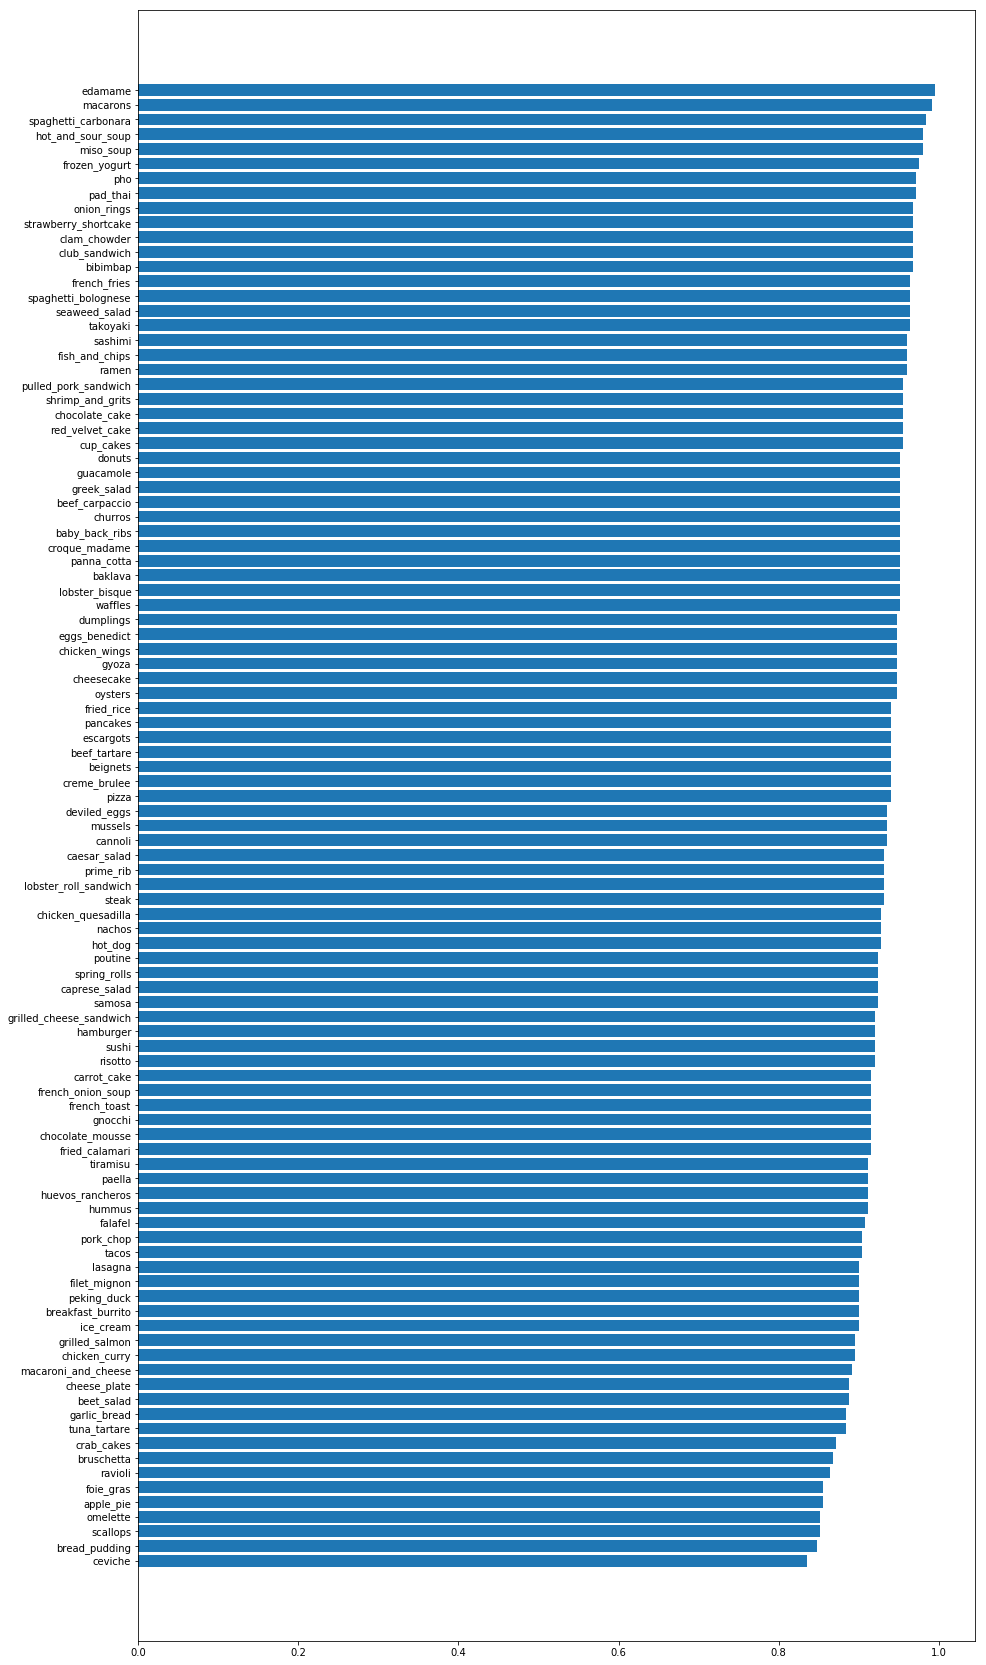

In [0]:
#top-5 accuracy per class (with TTA)
class_acc_top_5 = []
for i in range(n_classes):
  a = cats == i
  class_acc_top_5.append(np.sum(in_top_5 * a) / np.sum(a))
a = np.asarray(class_acc_top_5)
b = np.argsort(a)
c = np.unravel_index(b, b.shape)
fig = plt.figure(figsize=(15,30))
d = np.asarray(class_list)
plt.barh(d[c],a[c])

## Conclusions

This has proved to be a difficult dataset for a classification model to learn.

The model trained here reaches a top-1 accuracy of 73.2% top-5 accuracy of 91.5%. With test time augmentation, the model reaches a top-1 accuracy of 75.8% and a top-5 accuracy of 93.0%.

There looks to be some overtraining but also the network has not achieved the accuracy that is possible on this dataset, so there is a problem of both high bias and high variance.

Possible ways to improve on this would be to adjust the classification layers of the network and scaling the learning rates for the different layers.
